## Import libraries

In [55]:
import numpy as np
import cv2
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt

## Set up blob detector

In [94]:
# Setup SimpleBlobDetector parameters.
blobParams = cv2.SimpleBlobDetector_Params()

# Change thresholds
blobParams.minThreshold = 0
blobParams.maxThreshold = 255

# Filter by Area.
blobParams.filterByArea = True
blobParams.minArea = 10    # minArea may be adjusted to suit for your experiment
blobParams.maxArea = 10000   # maxArea may be adjusted to suit for your experiment

# Filter by Circularity
blobParams.filterByCircularity = True
blobParams.minCircularity = 0.0001

# Filter by Convexity
blobParams.filterByConvexity = True
blobParams.minConvexity = 0.001

# Filter by Inertia
blobParams.filterByInertia = True
blobParams.minInertiaRatio = 0.001

# Create a detector with the parameters
blobDetector = cv2.SimpleBlobDetector_create(blobParams)

# blobDetector = cv2.SimpleBlobDetector()

## Get images

In [95]:
 # path
path = "../from_nas/imgs"

images = []
for folder in os.listdir(path):
    tmp_path = os.path.join(path, folder, "*.png")
    print(f"{tmp_path = }")
    images.extend(glob.glob(tmp_path))

tmp_path = '../from_nas/imgs\\01.Image\\*.png'
tmp_path = '../from_nas/imgs\\02.Image\\*.png'
tmp_path = '../from_nas/imgs\\03.Image\\*.png'


## Set up a zero-array for `world points 

In [96]:
# termination criteria
subpix_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC # + cv2.fisheye.CALIB_CHECK_COND
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

## Find Circles-grid

In [97]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
img_new_list = []

pixels_to_shrink = 1500
pixel_pattern_map = dict()
pixel_pattern_map[500] = (8, 8)
pixel_pattern_map[650] = (10, 10)
pixel_pattern_map[750] = (12, 12)
pixel_pattern_map[850] = (14, 14)
pixel_pattern_map[900] = (14, 14)
pixel_pattern_map[980] = (16, 16)
pixel_pattern_map[1060] = (18, 18)
pixel_pattern_map[1500] = (28, 28)
pattern_size = pixel_pattern_map[pixels_to_shrink]

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)


objp = np.zeros((1, pattern_size[1]*pattern_size[0],3), np.float32)
objp[0,:,:2] = np.mgrid[0:pattern_size[0],0:pattern_size[1]].T.reshape(-1,2)

In [98]:
for idx, img_path in enumerate(images):
    img = cv2.imread(img_path)   

    H, W = img.shape[:2]
    H_start = (H - pixels_to_shrink) // 2
    H_end = H_start + pixels_to_shrink
    
    W_start = (W - pixels_to_shrink) // 2
    W_end = W_start + pixels_to_shrink
    img_new = img[H_start:H_end, W_start:W_end]

    # if idx in [1, 2]:
    #     cv2.imwrite(f"cropped_1500_{idx}.png", img_new)
    #     if idx == 2:
    #         break
    img_new = np.pad(img_new, ((H_start, H - H_end), (W_start, W - W_end), (0, 0)), 'constant', constant_values=255)
    img_new_list.append(img_new)
                     
    gray = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)
    
    # ret, corners = cv2.findCirclesGrid(gray, pattern_size, None, cv2.CALIB_CB_SYMMETRIC_GRID | cv2.CALIB_CB_CLUSTERING, blobDetector)
    ret, corners = cv2.findCirclesGrid(gray, pattern_size, None, cv2.CALIB_CB_SYMMETRIC_GRID | cv2.CALIB_CB_CLUSTERING)
    if ret:
        print(f"{ret = }, {corners.shape = }")
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), subpix_criteria)
        imgpoints.append(corners2)
        print(f"corners == corners2 in all? {(corners == corners2).all()}")

        # Draw and display the corners
        cv2.drawChessboardCorners(gray, (7,6), corners2, ret)
        cv2.imshow('img', gray)
        cv2.waitKey(3000)

    else:
        print("Not Found")

cv2.destroyAllWindows()

if len(objpoints) > 0:
    N_imm = len(objpoints)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_imm)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_imm)]
    rms, _, _, _, _ = cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))
else:
    print("No calibration")

Not Found
Not Found
Not Found
Not Found
Not Found
Not Found
Not Found
Not Found
Not Found
No calibration


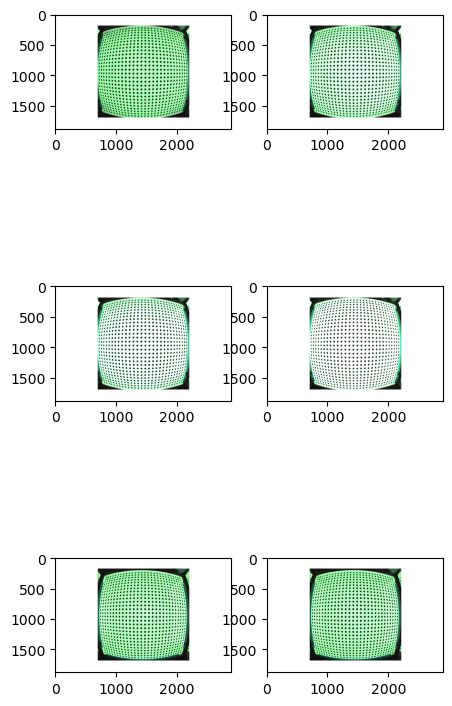

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(5, 10))
for i in range(3):
    for j in range(2):
        idx = i*2+j
        axes[i][j].imshow(img_new_list[idx])

plt.show()

In [66]:
# D = np.array([[15.7819579340676, -5.72318764899248e-06, 1.77468431533204e-10, -7.60521806174687e-13]]).T
dst = cv2.fisheye.undistortImage(img, K, D)

In [67]:
K

array([[1.00306745e+03, 0.00000000e+00, 1.43766452e+03],
       [0.00000000e+00, 1.00316839e+03, 9.49166743e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [68]:
D

array([[-6.99492239e-02],
       [-6.55709957e-01],
       [ 3.67978189e+01],
       [-2.90192802e+02]])

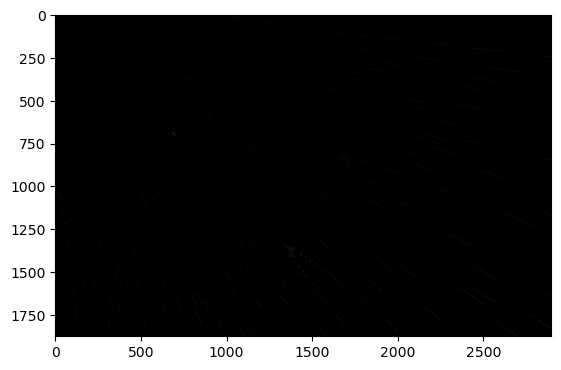

In [69]:
plt.imshow(dst)
plt.show()

In [47]:
dst.shape

(1876, 2896, 3)

In [17]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [18]:
# resizing
# mtx[0, -1] = mtx[0, -1] + (1500 - pixels_to_shrink)
# mtx[1, -1] = mtx[1, -1] + (1500 - pixels_to_shrink)
mtx[0, -1] = W / 2
mtx[1, -1] = H / 2
# print(f"{mtx = }")

h, w = imgs[2].shape[:2]

# note the order of size is width -> height, not height -> width
new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))


In [32]:
dst_fish = cv2.fisheye.undistortImage(imgs[2], mtx, dist[0, :4], None)

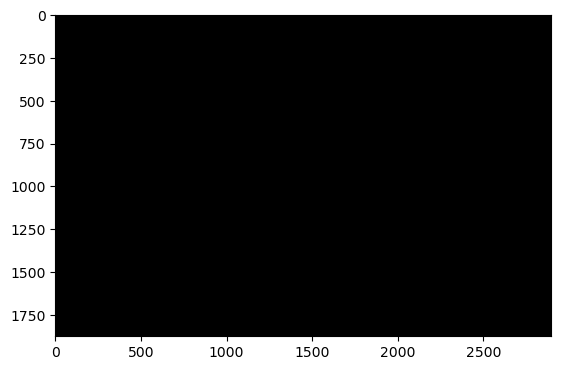

In [33]:
plt.imshow(dst_fish)
plt.show()

In [172]:
# test_mtx = [
#     [2670.12822326, 0, 1.48139826e+03],
#     [0, 1570.15941637, 9.13122290e+02],
#     [0, 0, 1]
# ]

# test_mtx = np.array(test_mtx)

In [173]:
# img_copy = imgs[0].copy()
# img_copy = cv2.resize(img_copy, (850*3, 850*3))

# plt.imshow(img_copy)
# plt.show()

In [212]:
# undistort
dst = cv2.undistort(imgs[2], mtx, dist, None, new_camera_mtx)

# crop the image
x, y, w, h = roi
dst2 = dst[y:y+h, x:x+w]


cv2.imwrite("original.png", imgs[2])
cv2.imwrite('calibresult.png', dst2)

True

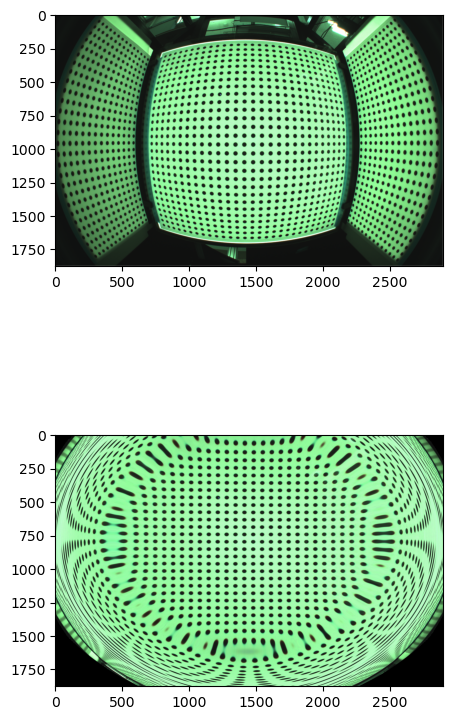

In [213]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
axes[0].imshow(imgs[2])
axes[1].imshow(dst)
plt.show()

In [214]:
roi

(0, 0, 2895, 1548)

In [11]:
# save the matrix, if needed
np.savez("new_camera_mtx.npz", new_camera_mtx)

In [12]:
# Re-projection Error
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print(f"total error: {mean_error / len(objpoints)}")

total error: 81.49002773798638


In [ ]:
# for fname in images:
#     img = cv.imread(fname)
#     gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
#     # Find the chess board corners
#     ret, corners = cv.findChessboardCorners(gray, (7,6), None)
 
#     # If found, add object points, image points (after refining them)
#     if ret == True:
#     objpoints.append(objp)
 
#     corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
#     imgpoints.append(corners2)
 
#     # Draw and display the corners
#     cv.drawChessboardCorners(img, (7,6), corners2, ret)
#     cv.imshow('img', img)
#     cv.waitKey(500)
 
# cv.destroyAllWindows()

In [48]:
import pandas as pd

df_corners = pd.DataFrame(corners2.reshape(-1, 2))
df_objp = pd.DataFrame(objp)
df_corners.to_csv("circle_points.csv", header=False, index=False)
df_objp.to_csv("world_points.csv", header=False, index=False)